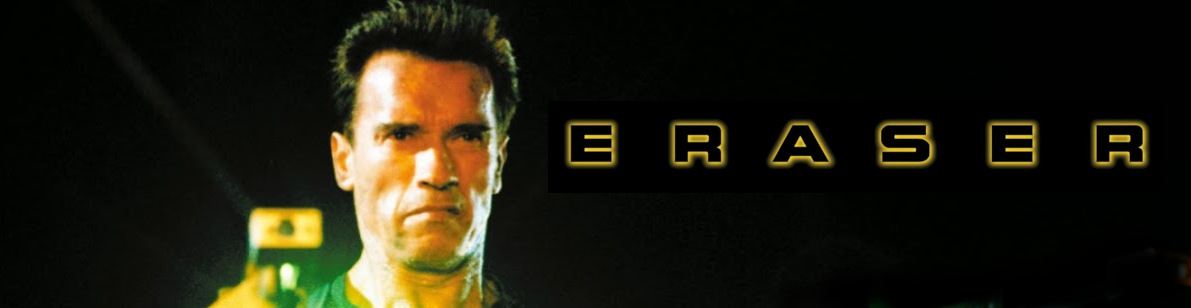

This notebook uses R. Change Kernel to R if needed with *Kernel* -> *Change kernel*.

It helps understand how much space is used in the workspace, and assists in erasing the files you don't want to keep. It can erase files selected by size, date, extension while protecting those in the workspace's Tables or in specific submissions.

**Limitations**
1. We look for paths with `/*/call-*` to identify files produced by workflows. If some files were manually uploaded and match that path, they might get erased (assuming they are not protected by other mechanisms like being in a table for example).
1. When protecting specific submissions, it assumes that the path is in the form `gs://<BUCKET>/submissions/<SUBMISSION>/*`. If the submission ID is not there in the filename, they might not get protected.

# Load packages

In [1]:
suppressMessages(library(AnVIL))
BUCKET = avbucket()
BUCKET

[1] "gs://fc-secure-8fd6fd6f-40f9-4048-a660-bc857a319ab8"

# How much space is being used currently?

In [2]:
system(paste0("gsutil du -sh ", BUCKET), intern=TRUE)

[1] "76.96 TiB    gs://fc-secure-8fd6fd6f-40f9-4048-a660-bc857a319ab8"

# List all files in the bucket

Also save to a "checkpoint" file in case the kernel dies.

In [3]:
du.o = system(paste0("gsutil ls -l ", BUCKET, "/**"), intern=TRUE)
saveRDS(du.o, file='duo.RDS')

This might take a few minutes depending on the number of files in the workspace. That's why we save the output in a file that can be loaded with:

In [66]:
du.o = readRDS('duo.RDS')

Convert to data frame.

In [67]:
du.df = tibble(
    size=as.numeric(gsub(" *([^ ]+) .*", "\\1", du.o)),
    date=gsub(paste0(" *[0-9]+ *([^ ]+)T.*"), "\\1", du.o),
    file=gsub(paste0(".*", BUCKET, "/([^ ]+) *.*"), "\\1", du.o)    
)

Warning message in eval_tidy(xs[[j]], mask):
“NAs introduced by coercion”


There was a warning about a "NA" when converting the sizes to "numeric". Make sure thatit was just the line with the TOTAL stats, and remove from the data frame.

In [68]:
du.df %>% filter(is.na(size))
du.df = du.df %>% filter(!is.na(size))

size,date,file
<dbl>,<chr>,<chr>
NA,"TOTAL: 54317 objects, 84623903524516 bytes (76.96 TiB)","TOTAL: 54317 objects, 84623903524516 bytes (76.96 TiB)"


Prepare some columns to get:
- `filen` filenames
- `size.mb` size in Mb
- `date` dates
- `extension` file extension, with a bit of a hack to get longer extensions for `.gz` files. 
- `is.results` boolean guessing when files are results from workflows (if in the form `/*/-call-*`)
- `submission` submission id (or root directory if not).

In [69]:
## extract extension. If '.gz', extract one more suffix.
findExtension <- function(filenames){
    ifelse(grepl("\\.gz$", filenames),
           gsub('.*\\.(.+\\..+)', '\\1', filenames),
           gsub('.*\\.(.+)', '\\1', filenames))
}
du.df = du.df %>% 
    mutate(size.mb=size/(1024*1024), 
           filen=basename(file),
           date=strptime(date, "%Y-%m-%d"),
           extension=findExtension(filen), 
           is.results=grepl('/.+/call-', file),
           submission=gsub("submissions/", "", file), submission=gsub("([^/]+).*", "\\1", submission)) %>% 
    select(-size) %>% arrange(desc(size.mb))

Have a look at the data.frame.

In [ ]:
sample_n(du.df, 10)

# What's using storage?

For example, what types of files are using more than 0.5 Tb?

In [46]:
du.df %>% group_by(extension) %>% summarize(size.tb=round(sum(size.mb/(1024*1024)), 3)) %>% 
    filter(size.tb>=.5) %>% arrange(desc(size.tb))

extension,size.tb
<chr>,<dbl>
tar,58.453
bam,12.475
fastq.gz,5.410


Which root folder or submission is using the most space?

In [48]:
du.df %>% group_by(submission) %>% summarize(size.tb=round(sum(size.mb/(1024*1024)), 3)) %>% 
    arrange(desc(size.tb)) %>% head(10)

submission,size.tb
<chr>,<dbl>
fast5,55.424
raw_data,3.484
fastq,3.008
bam,2.305
dd1da09a-e677-4d83-ba19-9b9cf61f2f79,1.758
5a61bc01-868b-42d9-a763-b070e26c554d,1.509
caea7fe6-e776-4d40-b1a6-51249a22631c,0.730
6658dded-ce48-4ed4-9028-809815e10591,0.561
c5fcdd89-0f1e-423d-a8cd-bba3f8723739,0.502


# Load all the Terra Tables

And mark files that are in them in order to protect them from the erasing.

In [31]:
files.in.tables = unlist(lapply(avtables()$table, function(tabname){
    unlist(avtable(tabname))
}))
names(files.in.tables) = NULL

In [71]:
du.df = du.df %>% mutate(protected=paste0(BUCKET, "/", file) %in% files.in.tables)

How many files are now protected?

In [72]:
sum(du.df$protected)

[1] 495

For example:

In [ ]:
du.df %>% filter(protected) %>% sample_n(3)

# Protect specific submissions

Maybe you'd like to keep all the files from some submissions. For example, if runs are in progress or upcoming runs might be able to use cached jobs.

In [52]:
sub.tokeep = c('6658dded-ce48-4ed4-9028-809815e10591', 'fae1b345-15cd-4e53-bdc2-52c08b7c5b5e')

In [73]:
du.df = du.df %>% mutate(protected=protected | submission %in% sub.tokeep)

How many files are now protected?

In [74]:
sum(du.df$protected)

[1] 2722

# Erase temporary files

Temporary files can be defined in different ways. For example, we use:

1. All files that are not protected and, say, larger than 10 Mb (to save most log/script files)
1. All large unprotected files older than X days
1. All large unprotected files with/without X extension

Or a combination of those.

## Erase all large unprotected files

How much space is used by those files?

In [75]:
du.df %>% filter(is.results, !protected, size.mb>10) %>% 
    mutate(size.tb=size.mb/(1024*1024)) %>% .$size.tb %>% sum

[1] 6.195469

Check a few big files, just in case.

In [ ]:
du.df %>% filter(is.results, !protected, size.mb>10) %>% sample_n(10)

### Dry run

Write the list of files somewhere

In [80]:
outf = gzfile('toremove.tsv.gz', 'w')
du.df %>% filter(is.results, !protected, size.mb>10) %>% arrange(desc(size.mb)) %>% 
    mutate(size.gb=signif(size.mb/1024, 6)) %>% 
    select(size.gb, filen, date, file, everything(), -size.mb) %>% 
    write.table(outf, sep='\t', quote=FALSE, row.names=FALSE)
close(outf)

In [22]:
system(paste0('gsutil cp toremove.tsv.gz ', BUCKET, '/eraser-files/'), intern=TRUE)

character(0)

In [84]:
outf = gzfile('tokeep.tsv.gz', 'w')
du.df %>% filter(!is.results | protected | size.mb<=10) %>% arrange(desc(size.mb)) %>%
    mutate(size.gb=signif(size.mb/1024, 6)) %>% 
    select(size.gb, filen, date, file, everything(), -size.mb) %>% 
    write.table(outf, sep='\t', quote=FALSE, row.names=FALSE)
close(outf)

In [24]:
system(paste0('gsutil cp tokeep.tsv.gz ', BUCKET, '/eraser-files/'), intern=TRUE)

character(0)

Those files are ordered in decreasing order of file size. It's good to have a look, or at least skim, the lists to make sure it looks correct.

### ERASE FILES! DANGER

This code will erase the files. If you'd prefer more control over which files get erased (e.g. by size/date/extension etc), read below.

In [48]:
du.df %>% filter(is.results, !protected, size.mb>10) %>%
    mutate(file=paste0(BUCKET, "/", file)) %>% .$file %>% write(file='torm.txt', ncolumns = 1)

In [ ]:
system("cat torm.txt | gsutil rm -I", intern=TRUE)

This might also take a few minutes if there are a lot of files to remove.

## All large unprotected files older than X days

Use the same types of command as above, but with different "filters". 
For example, unprotected large files older than 30 days:

In [ ]:
du.df %>% filter(is.results, !protected, size.mb>10,
                 difftime(Sys.Date(), date, units="days")>30) %>% sample_n(10)

Note: the date filtering uses the *difftime* function to count the difference in days between the file's date and today (provided by `Sys.Date()`).

## All large unprotected files with/without X extension

Same idea, but this time specifying filters on the `extension`.
For example, if we want to remove all unzipped FASTQs and BAMs:

In [ ]:
du.df %>% filter(is.results, !protected, size.mb>10,
                 extension %in% c("bam", "fastq", "fq")) %>% sample_n(10)

Or we want to keep CSV files and let's say all VCFs:

In [ ]:
du.df %>% filter(is.results, !protected, size.mb>10,
                 !(extension %in% c("csv", "vcf", "vcf.gz"))) %>% sample_n(10)

## Custom filters

Sometimes you might know exactly the task to clean up, or a specific pattern in the path. 
That can also be added to the filtering.

For example, to delete files from a task named *taskWithTemp* (the path will contain the task name):

In [ ]:
du.df %>% filter(is.results, !protected, size.mb>10, grepl("taskWithTemp", file)) %>% sample_n(10)